# Nvidia Linear Forecasting

## Setup

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import mplfinance as mpf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import pickle

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the datafram called 'df'

In [2]:
# Read the csv file into a pandas DataFrame
df = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df = df.loc[start_date:end_date]

In [3]:
log_returns = df['NVDA_LOGRET'].copy()

log_returns.index = pd.DatetimeIndex(log_returns.index).to_period('D')

Then we prepare a train/test split for the Nvidia log return series which we will use later for fitting and testing the ARMA and GARCH models. In this instance, we cut the last 60 days for testing and the rest is used for training.

In [4]:
train, test = log_returns[:-60], log_returns[-60:]

In [5]:
month_year_formatter = mdates.DateFormatter('%Y-%m') # The "," is intentional.
locator = mdates.MonthLocator(interval=3)

## Functions

In [6]:
def pricePlot():

    # Plot the NVDA log return series
    fig, ax = plt.subplots(figsize=(20,10))

    # Change figure facecolor (area surrounding the plot)
    fig.patch.set_facecolor('white')

    # Change plot facecolor (actual plot background)
    ax.set_facecolor('whitesmoke')

    # Change axes color
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')

    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')

    ax.plot(df['NVDA_CLOSE'], color='royalblue')

    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(month_year_formatter)

    fig.autofmt_xdate()

    plt.title('NVDA Price Series')
    plt.xlabel('Date')
    plt.ylabel('Adj. Close Price')
    plt.grid(True, color='white')
    plt.show()


In [7]:
def logReturnPlot():

    # Plot the NVDA log return series
    fig, ax = plt.subplots(figsize=(20,10))

    # Change figure facecolor (area surrounding the plot)
    fig.patch.set_facecolor('white')

    # Change plot facecolor (actual plot background)
    ax.set_facecolor('whitesmoke')

    # Change axes color
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.title.set_color('black')

    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')

    ax.plot(df['NVDA_LOGRET'], color='royalblue')

    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(month_year_formatter)

    fig.autofmt_xdate()

    plt.title('NVDA Log Return Series')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True, color='white')
    plt.show()


In [8]:
def candlestickPlot():

    # Select only the NVDA columns
    nvda_df = df[["NVDA_OPEN", "NVDA_HIGH", "NVDA_LOW", "NVDA_CLOSE", "NVDA_VOLUME"]]

    # Slice the DataFrame for the desired date range
    nvda_df = nvda_df.loc['2023-01-01':'2023-07-01']

    # Rename columns to standard OHLC names
    nvda_df.columns = ["Open", "High", "Low", "Close", "Volume"]

    # Define Moving Average parameters
    mav_titles = ['MA10','MA20','MA30']
    mavs = [10,20,30]
    colors = ['b', 'g', 'r']

    # Create a custom style to increase figure size
    mc = mpf.make_marketcolors(up='g',down='r')
    s = mpf.make_mpf_style(marketcolors=mc)
    s['figure.facecolor'] = 'lightgray'

    # Add MAV and volume to the plot
    apds = [mpf.make_addplot(nvda_df['Close'].rolling(mav).mean(), color=color) for mav, color in zip(mavs, colors)]

    # Create the plot
    fig, axes = mpf.plot(nvda_df, type='candle', style=s, addplot=apds, title='Nvidia Stock Price',
                        ylabel='Price ($)', figsize=(20,10), volume=True, returnfig=True)

    # Create custom legend
    lines = [mlines.Line2D([], [], color=color) for color in colors]
    axes[0].legend(lines, mav_titles, loc='upper left')

## Inspection

### Simple Daily Stock Price Plot

Below, we plot a simple time series graph of the daily adjusted close prices for Nvidia stock.

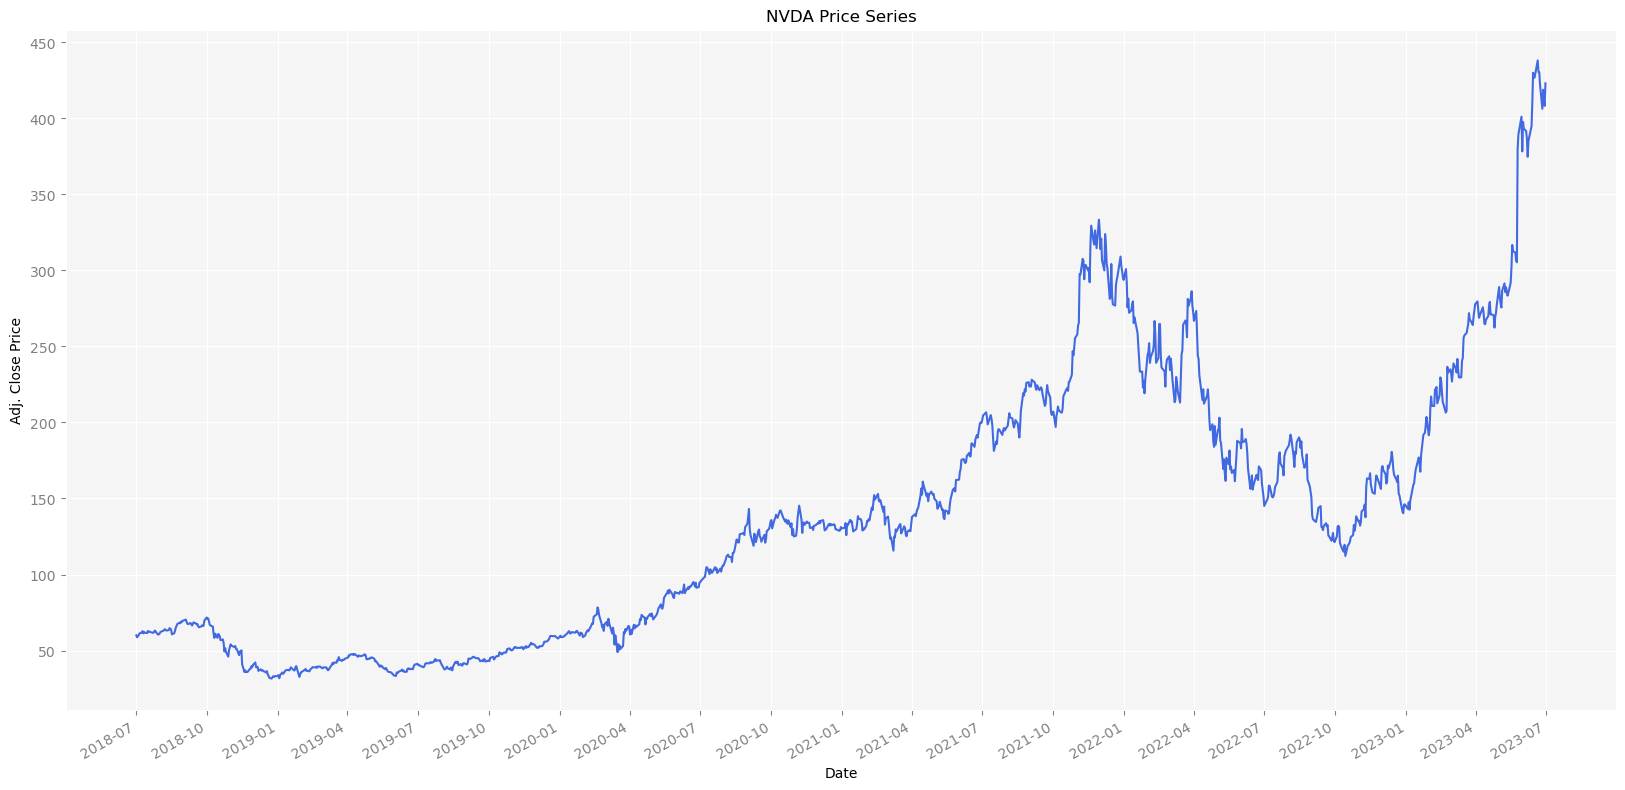

In [9]:
pricePlot()

### Daily Stock Price Candlestick Plot

Below, we plot the candlestick graph for the daily prices of Nvidia stock with moving averages over 10, 20 and 30 days and volume data on the lower part of the graph.

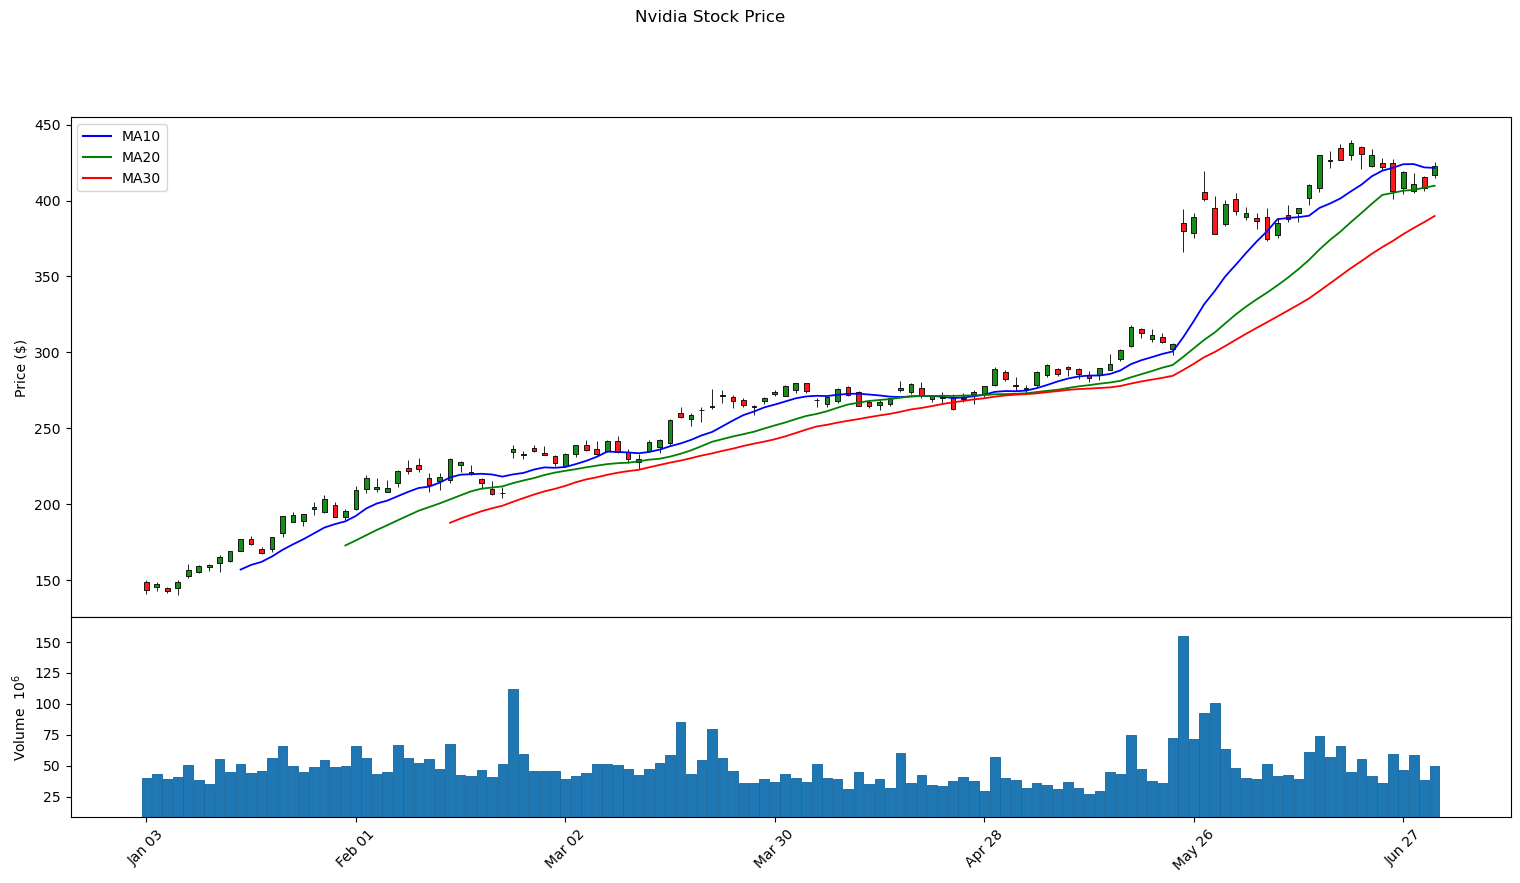

In [10]:
candlestickPlot()

### Log Return Plot

Below, we plot the log returns for Nvidia stock

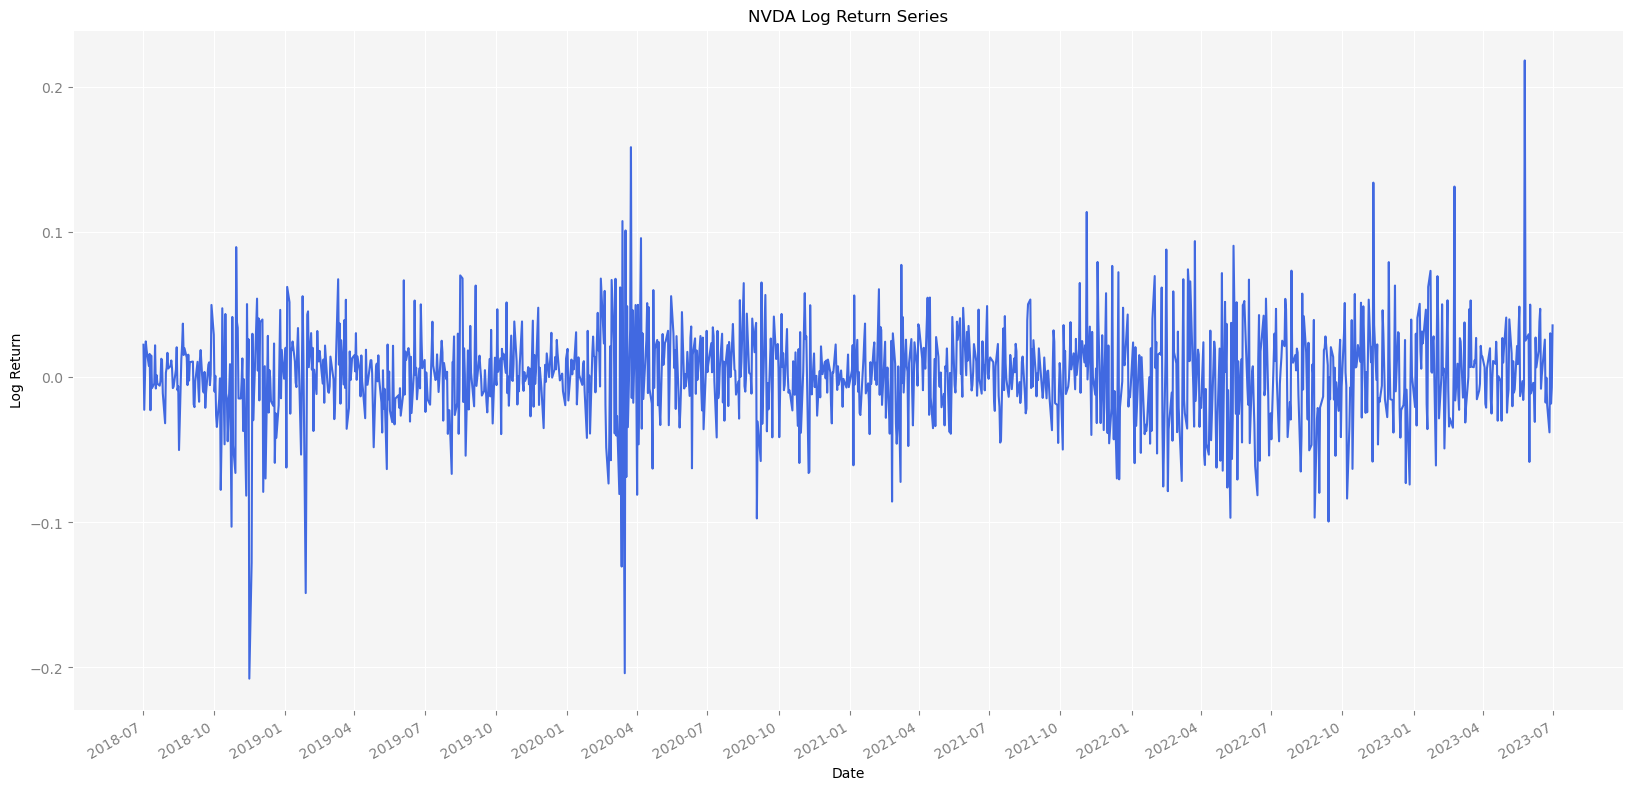

In [11]:
logReturnPlot()

### Autocorrelation Function (ACF)

Here we generate the ACF from the squared log returns of Nvidia stock

The reasons for squaring the log returns are as follows:

* Variance Stabilization: By squaring the log returns, we transform the data and stabilize its variance. Financial time series data often exhibits heteroscedasticity, meaning that the volatility or variance of returns changes over time. Taking the log returns helps in normalizing the distribution of returns, but it does not address the changing variance. Squaring the log returns further stabilizes the variance and makes the data more suitable for analysis.

* Capturing Non-linear Dependencies: Squaring the log returns helps capture potential non-linear dependencies or patterns in the data. Linear autocorrelation measures, such as the standard ACF, are useful for detecting linear relationships between lagged observations. However, financial markets often exhibit complex and non-linear dynamics. Squaring the log returns can reveal nonlinear dependencies that might be missed by considering only linear relationships.

* Focus on Magnitude of Returns: In financial analysis, the magnitude of returns is often of interest. By squaring the log returns, we emphasize the magnitudes of returns and their relationships over time. This can be particularly relevant when studying market volatility, as extreme positive or negative returns can have significant implications.

* By squaring the log returns, we address the issues of variance stabilization, non-linear dependencies, and the focus on return magnitudes, providing a more comprehensive analysis of financial time series data. However, it is important to note that the decision to square log returns may depend on the specific objectives of the analysis and the characteristics of the data being studied.

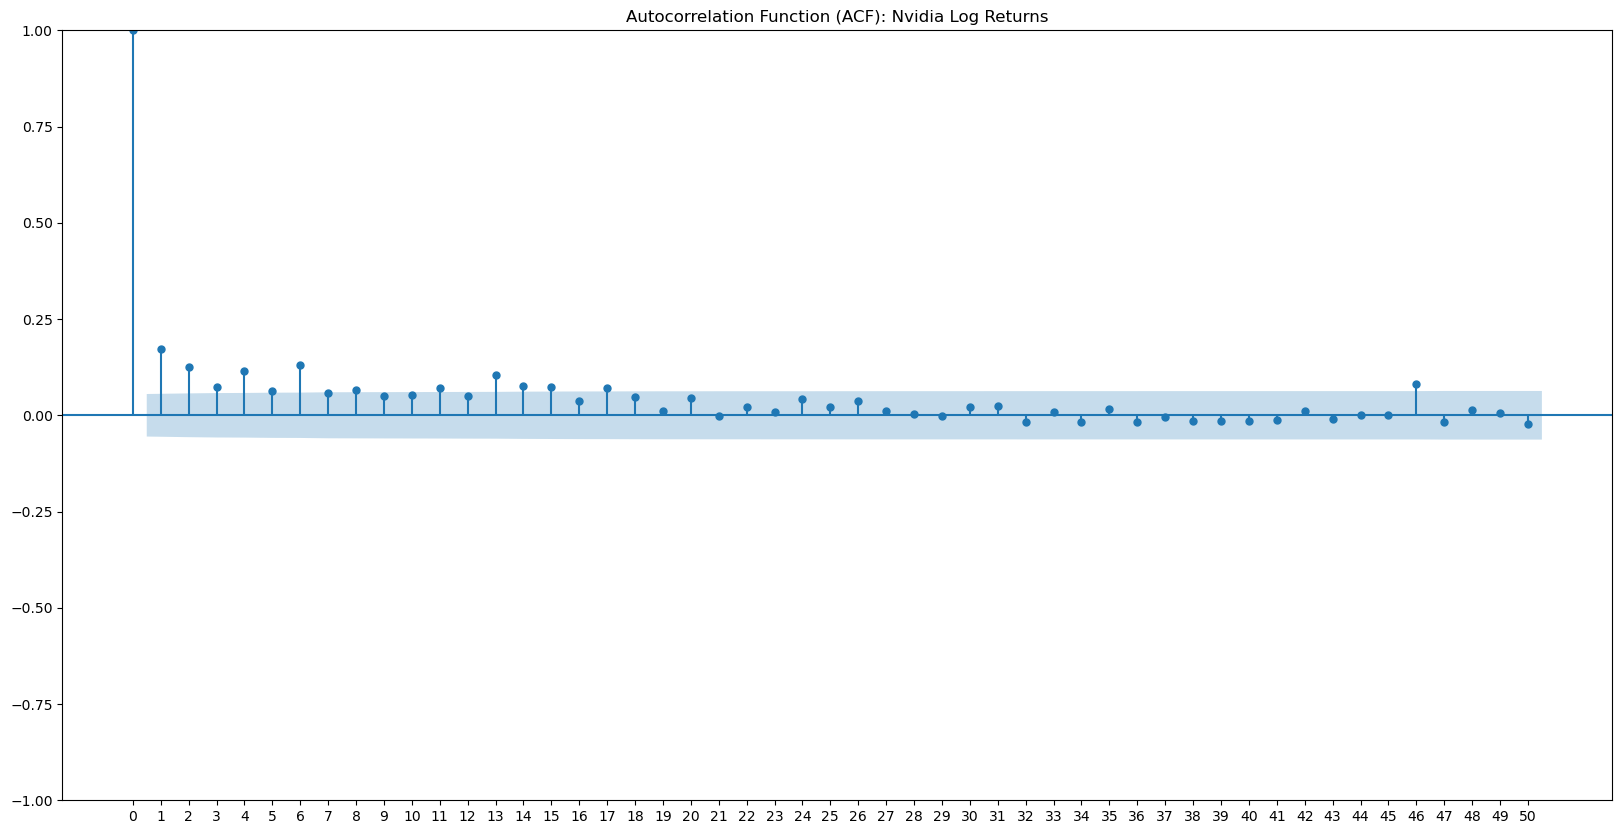

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
acf_plot = plot_acf(df['NVDA_LOGRET']**2, lags=50, title='Autocorrelation Function (ACF): Nvidia Log Returns', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

Points that fall outside of the 95% confidence interval (blue region) can indicate the presence of statistically significant autocorrelations at the respective lags. We observe the most significant instances of this at lags of 2, 3, 5, 6 and 13. These observations will impact the decisions we make later on when fitting an ARMA model to the data in the following ways:

* Model Selection: The presence of statistically significant autocorrelations suggests that the time series has some degree of dependence on its past values. This implies that an ARMA model, which explicitly models the autocorrelation structure, may be appropriate for capturing the dynamics of the data. The identification of significant autocorrelations helps guide us towards considering an AR component (ARMA) or an MA component (ARMA) in the model.

* Lag Selection: The lags with statistically significant autocorrelations indicate the time points at which the past values of the series have a significant influence on the current value. These lags can guide the selection of appropriate lag orders for the AR and MA components of the ARMA model. For example, if there is a significant positive autocorrelation at lag 1, it suggests that the AR component may be relevant, and an AR lag of 1 could be included in the model.

* Model Specification: The identification of significant autocorrelations helps determine the appropriate orders (p, q) for the ARMA model. The parameter p represents the order of the autoregressive component, indicating the number of lagged values to include, while q represents the order of the moving average component, indicating the number of lagged errors to include. The statistically significant autocorrelations in the ACF plot can guide the selection of suitable values for p and q.

* Model Diagnostic Checking: After fitting an ARMA model, it is important to assess its adequacy and validity. The presence of statistically significant autocorrelations at lags not accounted for by the model (i.e., residuals showing autocorrelation) could indicate that the model does not fully capture the dynamics of the data. In such cases, further model refinement may be required, such as increasing the model order or considering alternative models.

The most important takeaway from this, however, is that the ACF will inform our decision for the 'q' parameter, or the 'MA' component, of our ARMA model.

### Partial Autocorrelation Function (PACF)

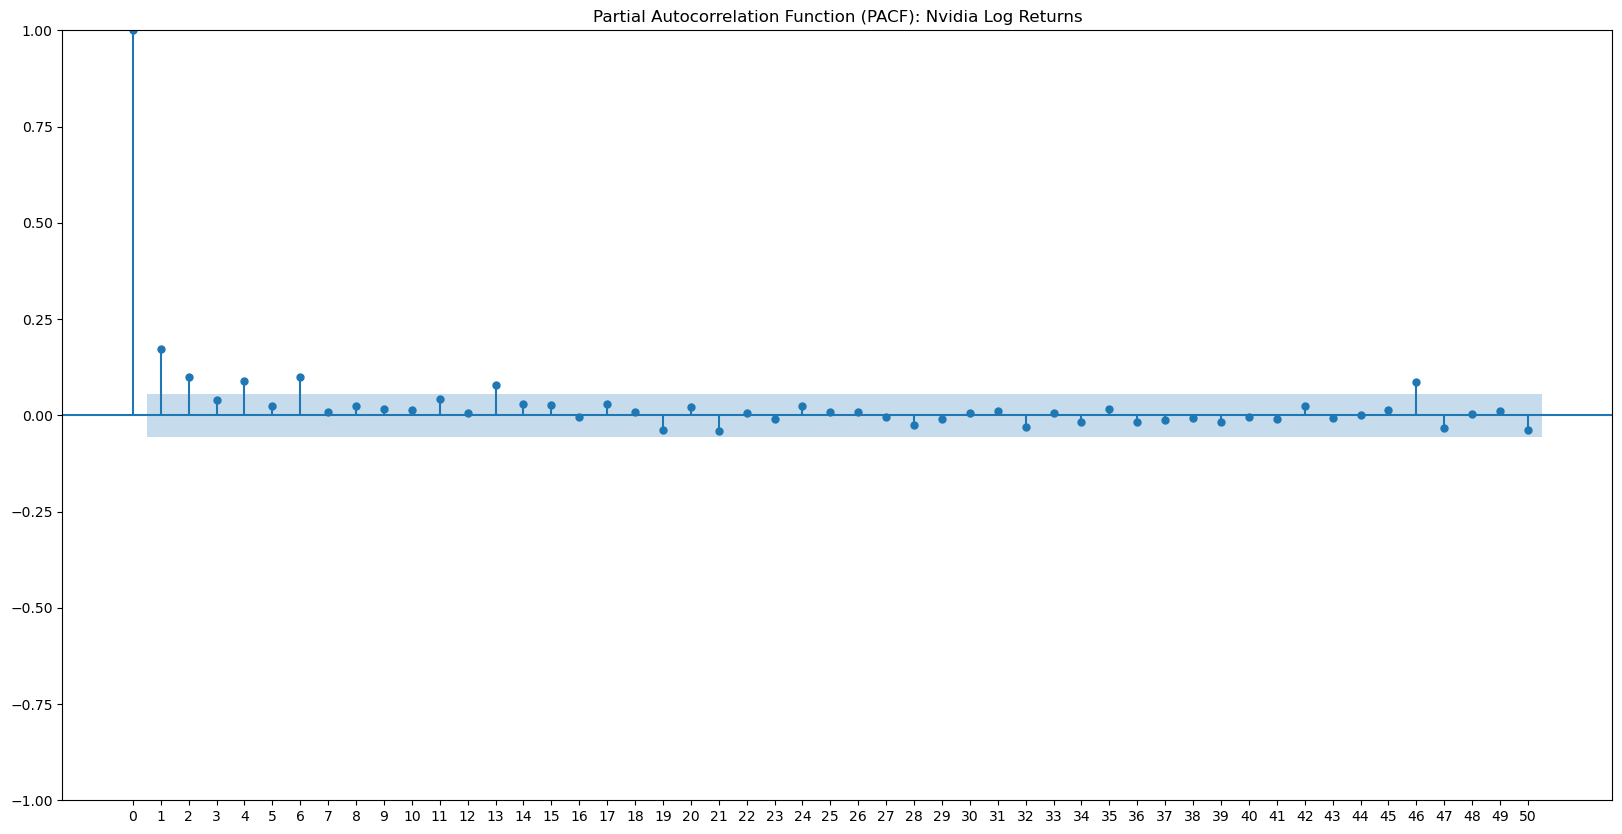

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
pacf_plot = plot_pacf(df['NVDA_LOGRET']**2, lags=50, method='ywm', title='Partial Autocorrelation Function (PACF): Nvidia Log Returns', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

PACF Interpretation: The PACF measures the correlation between a time series and its lagged values while controlling for the effects of the intermediate lags. It provides a more direct measure of the relationship between the series and its lagged values. Key uses of the PACF include:

* Identifying the presence of significant partial autocorrelations at specific lags.
* Estimating the order of the Autoregressive (AR) component in an ARMA model.
* Determining the appropriate lag structure of the AR component, as it helps to isolate the direct influence of individual lags.

We observe the most signifiant autocorrelations at lags of 2, 3, 5 and 6

### Find Optimal ARMA Parameters

We use Akaike Information Criterion (AIC) combined with a grid search to identify the optimal parameters for our ARMA model.

In [14]:
# Define the maximum p and q for the ARMA model
max_p = 3
max_q = 3

# Initialise best AIC to a large value
best_aic = np.inf
best_arma_order = None

# Grid search for the optimal ARMA parameters
for p in range(max_p + 1):
    for q in range(max_q + 1):
        try:
            model = sm.tsa.ARIMA(train, order=(p, 0, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_arma_order = (p, 0, q)
        except:
            continue

print(f'Best ARMA order: {best_arma_order}')

c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best ARMA order: (2, 0, 2)


Now we fit a baseline ARMA model using these optimal parameters and extract the residuals for use in optimisiaing and fitting the GARCH model in the next stage

In [15]:
arma_base_model = sm.tsa.ARIMA(train, order=(2,0,2))
arma_base_res = arma_base_model.fit()

base_residuals = arma_base_res.resid

### Check Autocorrelations in ARMA Residuals

Next we plot a new ACF on the residuals of our base ARMA model to check that there are no statistically significant autocorrelations

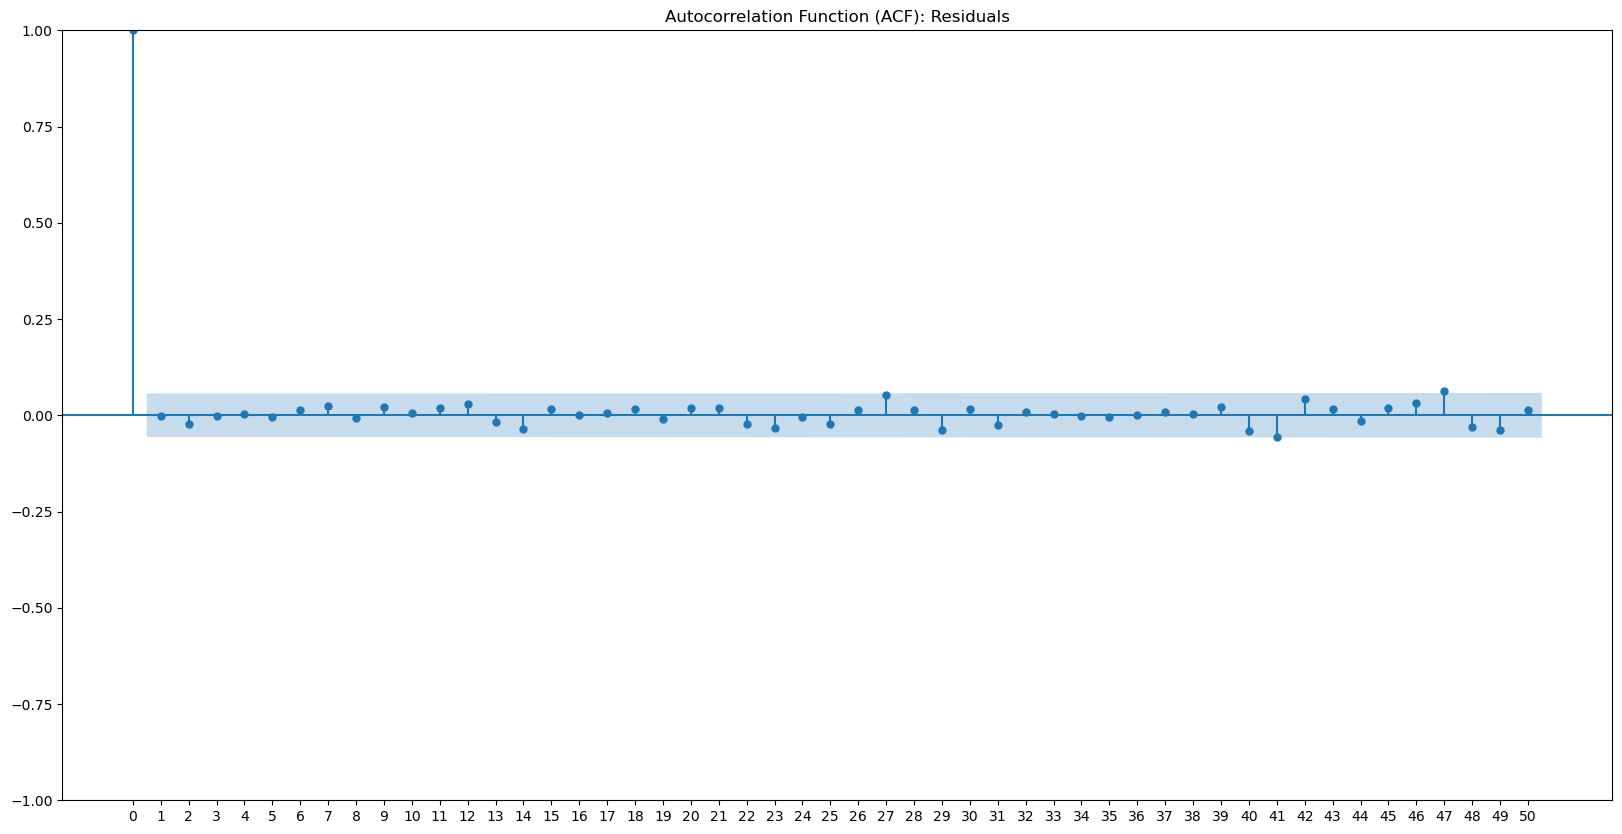

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
acf_plot = plot_acf(base_residuals, lags=50, title='Autocorrelation Function (ACF): Residuals', ax=ax)

# Add more x-axis markers
ax.set_xticks(range(0, 51, 1))  # Set the positions of the markers
ax.set_xticklabels(range(0, 51, 1))  # Set the labels for the markers

plt.show()

Looking at the above ACF, it is clear that we have successfully achieved "white noise" or maximum entropy in the residuals of the ARMA model

### Find Optimal GARCH Parameters

Similar to how we performed a grid search using the AIC to find the optimal ARMA parameters, we now perform the same procedure to find the optimal parameters for the GARCH model

In [17]:
# Define the maximum p and q for the ARMA model
max_p = 3
max_q = 3

# Initialise best AIC to a large value
best_aic = np.inf
best_garch_order = None

# Grid search for the optimal ARMA parameters
for p in range(max_p + 1):
    for q in range(max_q + 1):
        try:
            model = arch_model(base_residuals*10, vol='Garch', p=p, q=q)   # Here we scale the "y" by 10 since the grid search works better this way
            results = model.fit(update_freq=0)
            if results.aic < best_aic:
                best_aic = results.aic
                best_garch_order = (p, q)
        except:
            continue

print(f'Best GARCH order: {best_garch_order}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 354.91787224069776
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 289.32854199271827
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 289.32854181129676
            Iterations: 12
            Function evaluations: 88
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 285.09423500528317
            Iterations: 17
            Function evaluations: 139
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 336.35136185245915
            Iterations: 11
            Function evalua

## ARMA and GARCH Model

### Fit Model

Initialise the lists for storing the forecasted and actual log returns as well as the 'data' list which will initially hold the training dataset but will have the actual data points added to it incrementally as we progress through the procedure.

In [18]:
# Initialise lists to store forecasts and actuals
forecasts_logret = []
actuals_logret = []

# Use the training data to fit the initial model
data = train.copy()

Now we loop over the test dataset, each time re-training the ARMA and GARCH model with the latest data at that point in time and making a new, one-day-ahead forecast.

In [19]:
%%capture
for t in range(len(test)):
    # Fit the ARMA model to the data up to this point
    arma_model = sm.tsa.ARIMA(data, order=(best_arma_order[0], 0, best_arma_order[1]))
    arma_res = arma_model.fit()

    # Get the residuals from the ARMA model
    residuals = arma_res.resid

    # Fit the GARCH model on the residuals of the ARMA model
    garch_model = arch_model(residuals, vol='Garch', p=best_garch_order[0], q=best_garch_order[1])
    garch_res = garch_model.fit()

    # Make a one-step ahead forecast
    arma_forecast = arma_res.forecast(steps=1)
    garch_forecast = garch_res.forecast(start=0)

    # Combine the forecasts
    combined_forecast = arma_forecast[0] + np.sqrt(garch_forecast.variance.iloc[-1, :]) * np.random.normal(size=1)
    
    # Add the forecast to the list of forecasts
    forecasts_logret.append(combined_forecast[0])

    # Add the actual value to the list of actuals
    actuals_logret.append(test.iloc[t])
    
    # Add the new data point to the data
    data = pd.concat([data, test.iloc[t:t+1]])

Save/load model

In [26]:
# Save ARMA model
with open('arma_model.pkl', 'wb') as f:
    pickle.dump(arma_model, f)

# Save GARCH model
with open('garch_model.pkl', 'wb') as f:
    pickle.dump(garch_model, f)

'''
# Load ARMA model
with open('arma_model.pkl', 'rb') as f:
    arma_model = pickle.load(f)

# Load GARCH model
with open('garch_model.pkl', 'rb') as f:
    garch_model = pickle.load(f)
'''

Plot the forecasted vs actual log returns over the 60 day test period.

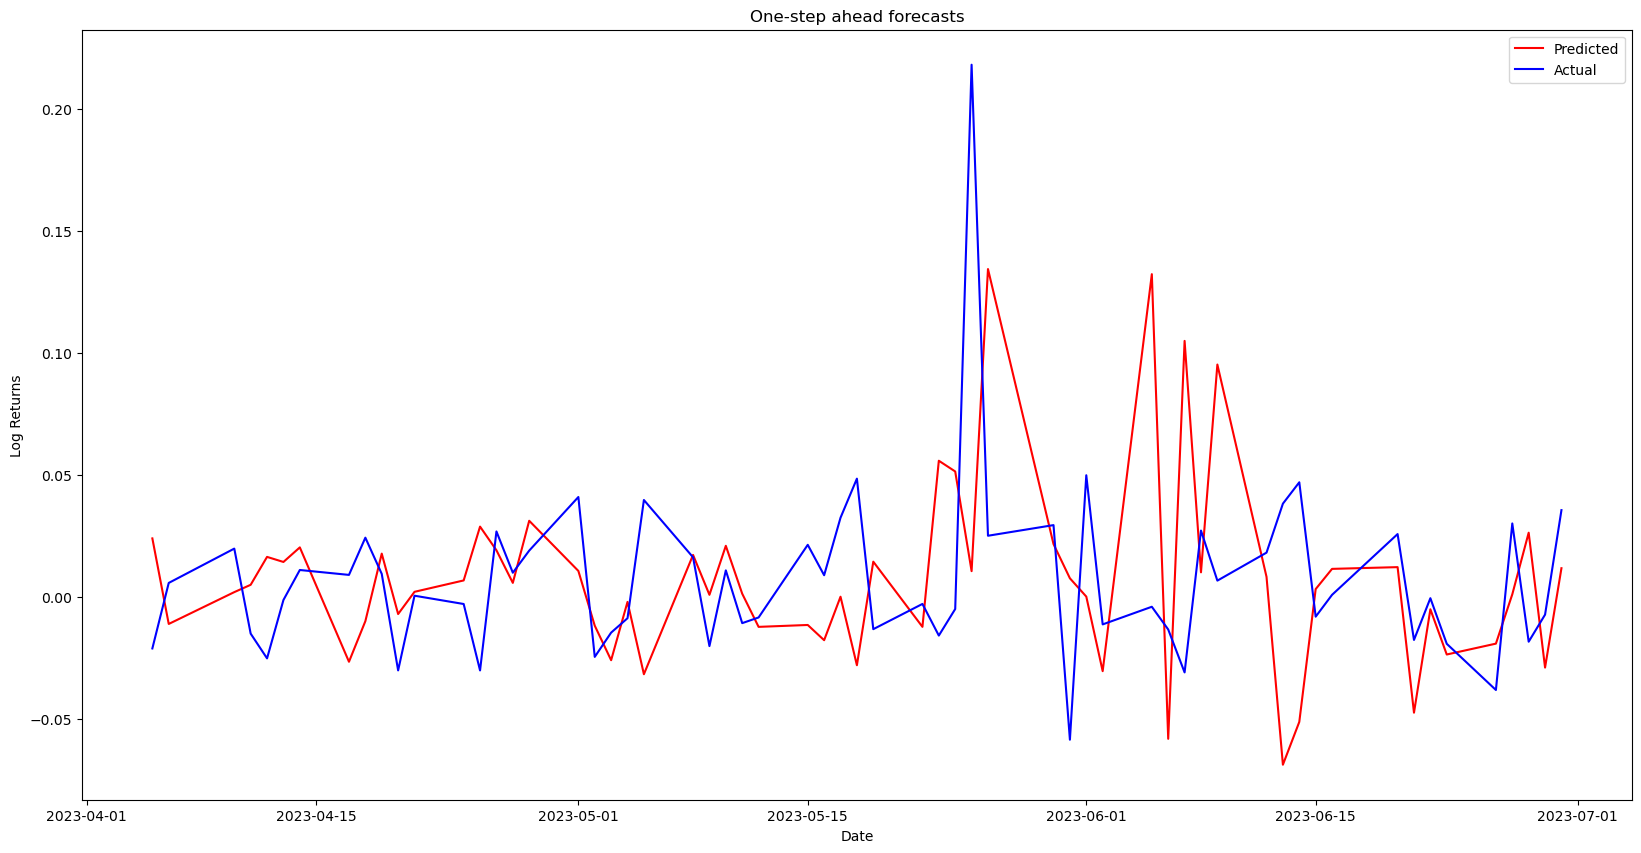

In [20]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_logret, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_logret, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Now we convert the log returns into standard returns

In [21]:
forecasts_ret = [np.exp(flogret) -1 for flogret in forecasts_logret]
actuals_ret = [np.exp(alogret) -1 for alogret in actuals_logret]

forecasts_cumulative_ret = [100]
actuals_cumulative_ret = [100]

for t in range(1, len(forecasts_ret)):
    forecasts_cumulative_ret.append(forecasts_cumulative_ret[t-1] + forecasts_ret[t])
    actuals_cumulative_ret.append(actuals_cumulative_ret[t-1] + actuals_ret[t])

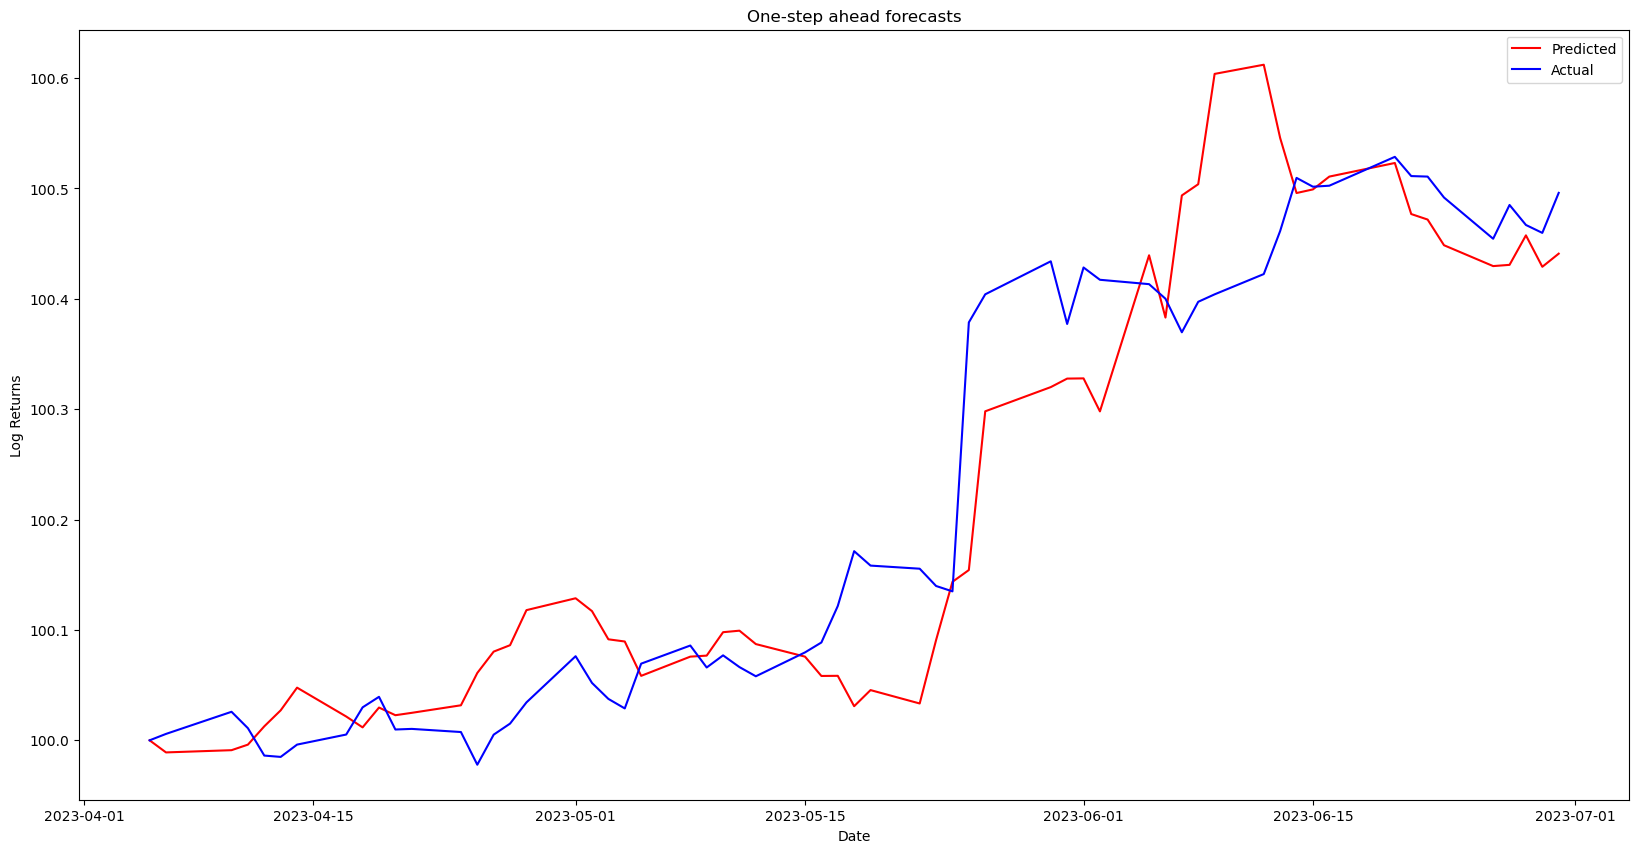

In [22]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_cumulative_ret, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_cumulative_ret, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Now we convert the cumulative returns to prices

In [23]:
forecasts_price = [df['NVDA_CLOSE'][-60]]
actuals_price = [df['NVDA_CLOSE'][-60]]

for t in range(1, len(forecasts_ret)):
    forecasts_price.append(forecasts_price[t-1] * (1 + forecasts_ret[t]))
    actuals_price.append(actuals_price[t-1] * (1 + actuals_ret[t]))

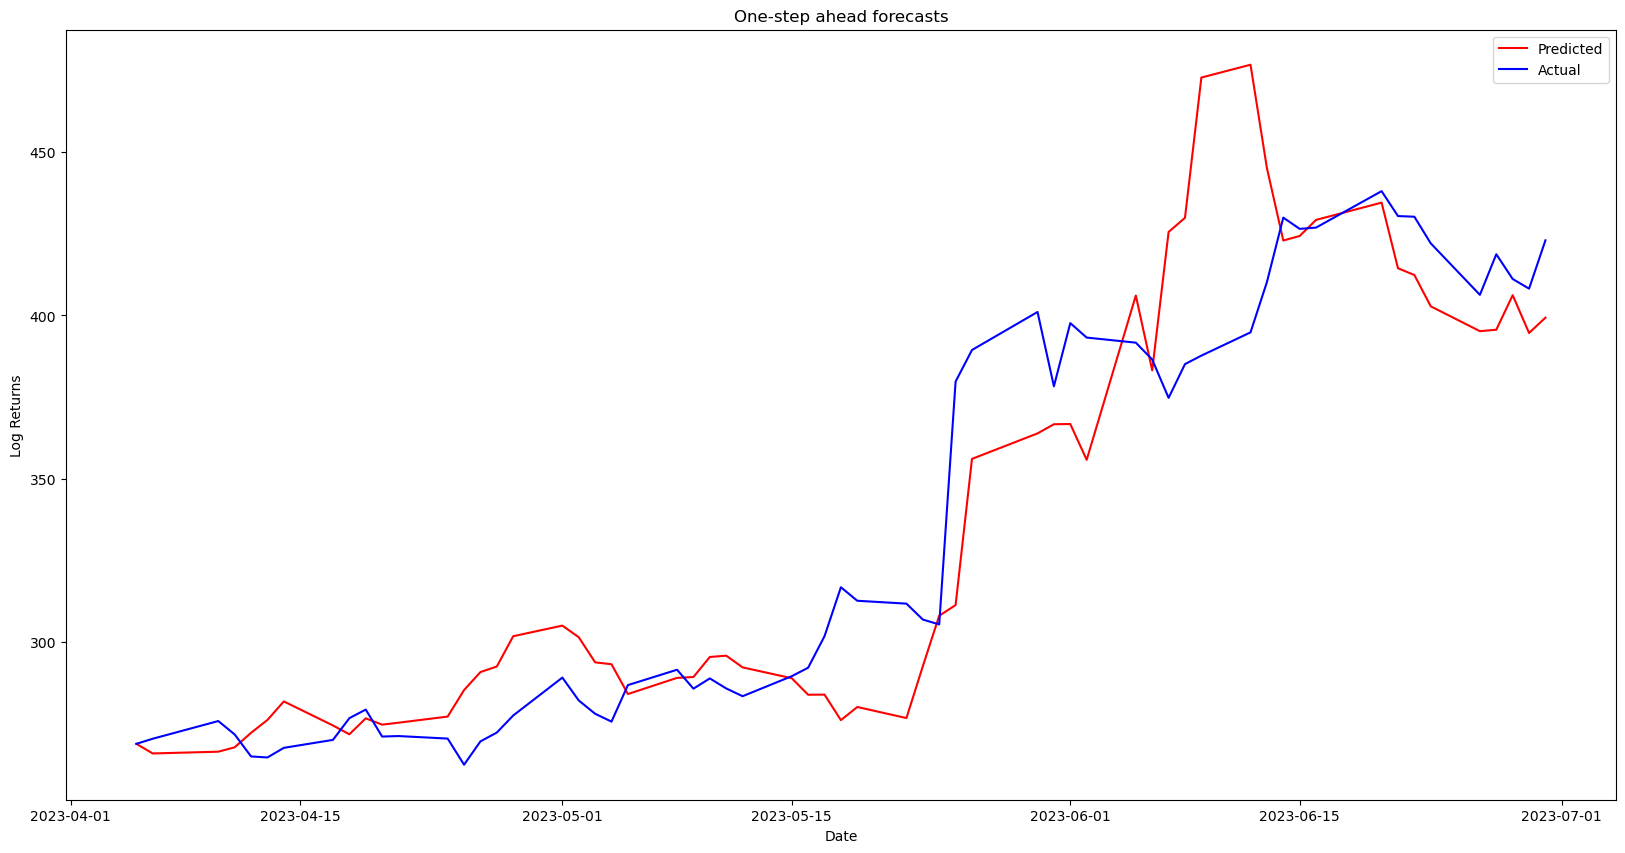

In [24]:
# Plot the forecasts against the actuals
plt.figure(figsize=(20, 10))
plt.plot(test.index.to_timestamp(), forecasts_price, color='red', label='Predicted')
plt.plot(test.index.to_timestamp(), actuals_price, color='blue', label='Actual')
plt.title('One-step ahead forecasts')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show()